# Categorical GPLVM
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\N}{\mathcal{N}}$
$\newcommand{\ddt}[1]{\dfrac{d #1}{ dt}}$

Trying to implement the model in [this paper](https://arxiv.org/pdf/1503.02182.pdf)

But first, a GP Classifier to learn how to workwith a categorical likelihood

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc("text", usetex=False)
rc("font", family = "serif")
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'

import os
from sklearn.utils import shuffle
import sklearn.datasets as datasets
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch
from torch.nn import Parameter
import pyro.ops.stats as stats
from sklearn.manifold import Isomap
from tqdm import trange

def plot2dproj(X,labels,method):
    for i in range(np.unique(labels).shape[0]):
        pts = X[labels==i]
        plt.scatter(pts[:,0],pts[:,1], s=3., label=str(i))
    plt.title( method+" Embedding",fontsize=16)
    plt.legend()
    plt.show()

In [127]:
n_train = 2000
xor_pts = 2*np.random.rand(n_train,2) - 1

In [128]:
xor_y = (xor_pts[:,0]*xor_pts[:,1]>0).astype(np.float)
xor_pts = xor_pts + 0.1*np.random.randn(n_train,2)

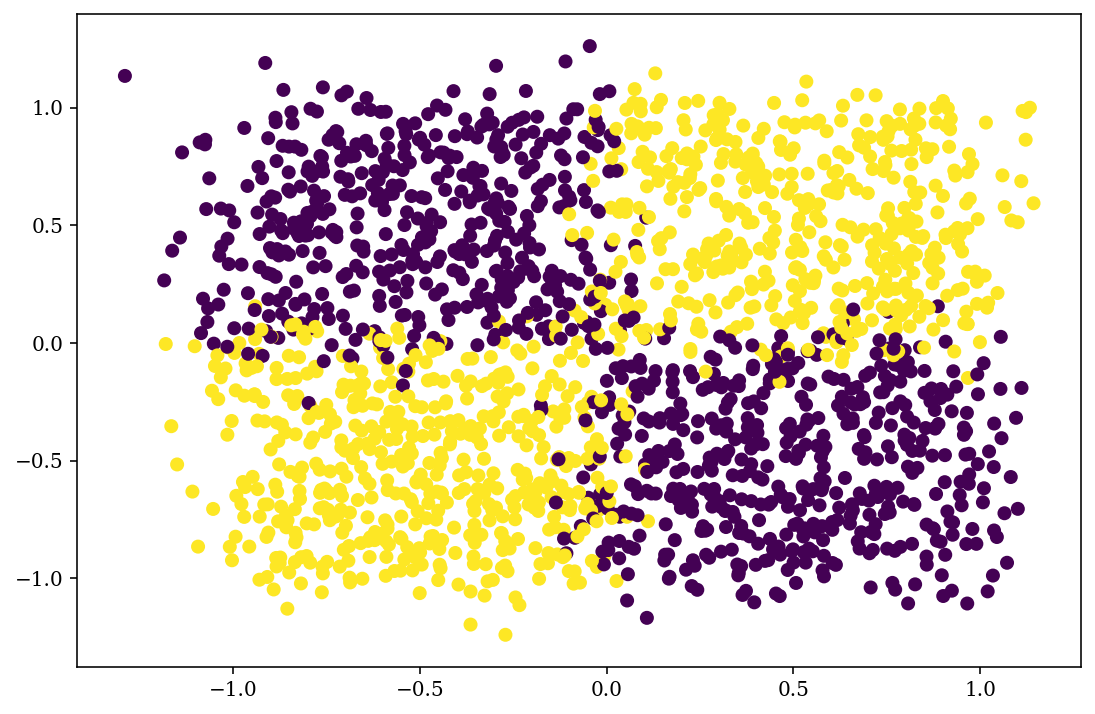

In [129]:
plt.scatter(xor_pts[:,0],xor_pts[:,1],c=xor_y)
plt.show()

In [133]:
X_xor = torch.tensor(xor_pts,dtype=torch.get_default_dtype()) 
Y_xor = torch.tensor(xor_y,dtype=torch.get_default_dtype())

rbf =  gp.kernels.RBF(input_dim=latent_dim,lengthscale = X_init.max(0)[0] - X_init.mean(0))
m12 = gp.kernels.Exponential(input_dim=latent_dim,lengthscale = X_init.max(0)[0] - X_init.mean(0))
m32 = gp.kernels.Matern32(input_dim=latent_dim,lengthscale = X_init.max(0)[0] - X_init.mean(0))
m52 = gp.kernels.Matern52(input_dim=latent_dim,lengthscale = X_init.max(0)[0] - X_init.mean(0))
classifier_K = rbf
classifier_K = gp.kernels.Sum(classifier_K,m52)
binary_likelihood = gp.likelihoods.Binary()
gpc = gp.models.VariationalGP(X_xor, Y_xor,kernel=classifier_K,likelihood=binary_likelihood,jitter=1e-4, whiten=True ) 

In [134]:
loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss

In [135]:
losses = gp.util.train(gpc, loss_fn=loss_fn)

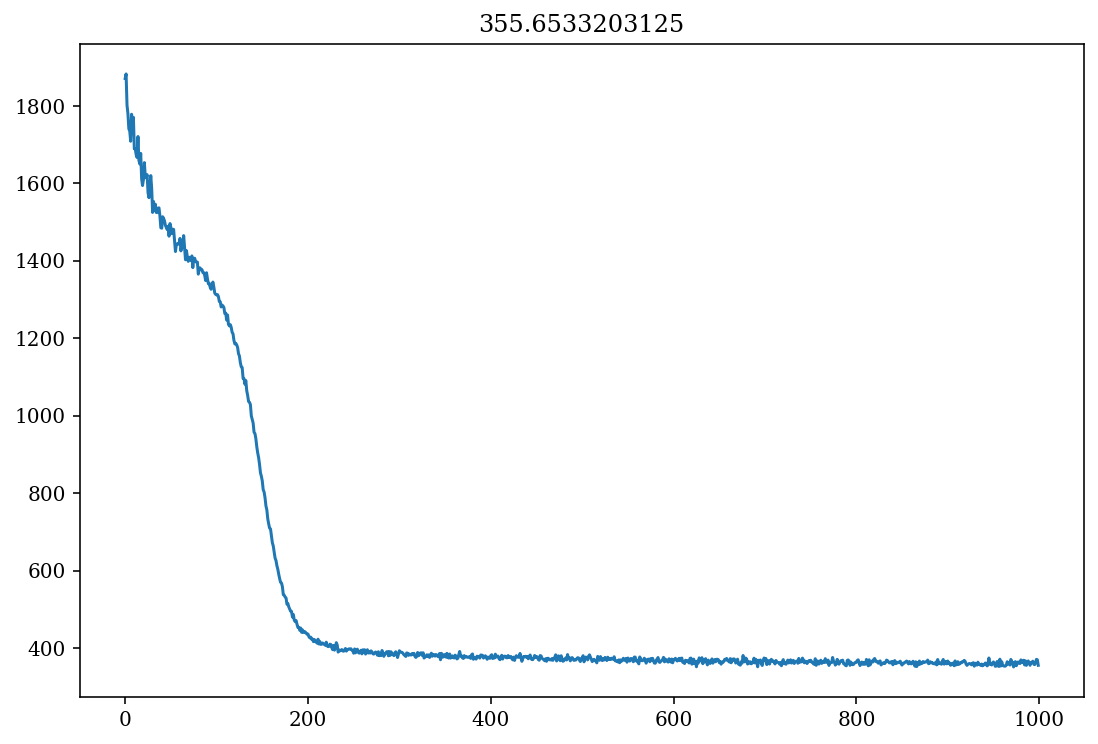

In [136]:
plt.plot(losses)
plt.title(losses[-1])
plt.show()

In [137]:
n_test = 500
xor_test_np = 2*np.random.rand(n_test,2) - 1
xor_test = torch.tensor(xor_test_np, dtype=torch.get_default_dtype())
xor_test_true = ((xor_test[:,0]*xor_test[:,1])>0)*1.

In [138]:
f_loc, f_var = gpc(xor_test)

In [139]:
binary_pred = gpc.likelihood(f_loc, f_var)

In [144]:
binary_pred.eq(xor_test_true).detach().sum()*1./500.

tensor(0.9380)

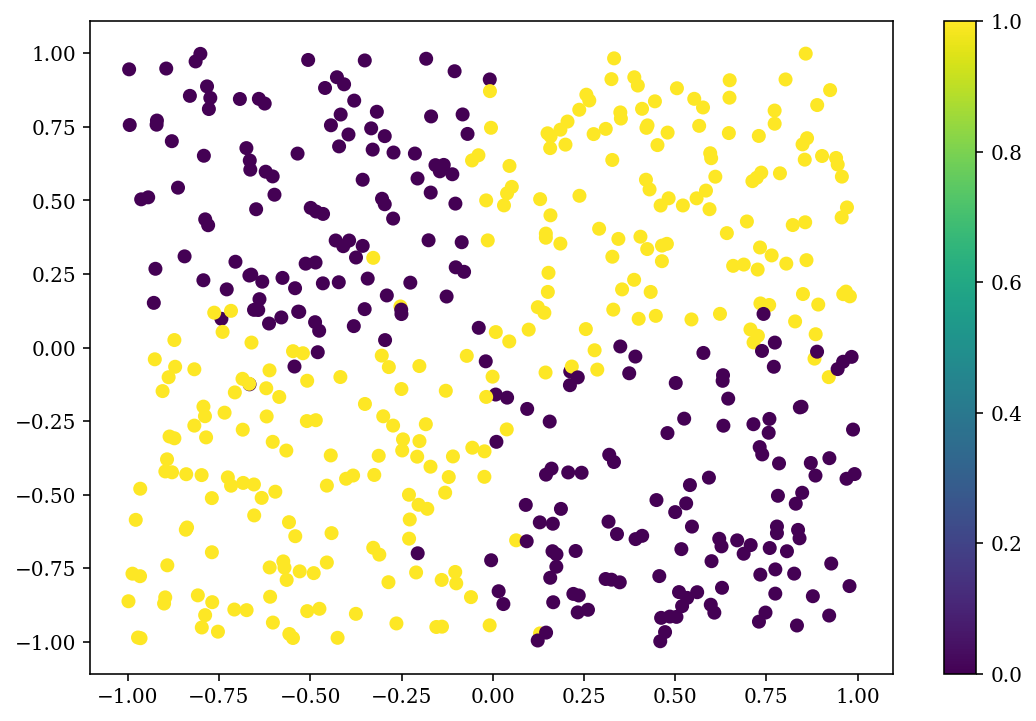

In [145]:
plt.scatter(xor_test_np[:,0],xor_test_np[:,1],c=binary_pred.detach().numpy())
plt.colorbar()
plt.show()

### GP Classificiation of the binarized digits dataset

As I understand the model is

$$ x_i \sim \N(0, \mathbb{I}) \ \ \ \ \ \ x_i \in \R^2$$
$$ f \sim \mathcal{GP}(0, RBF(x_i,x_j)) \ \ \ \ \ \ f: \R^2 \rightarrow \R^{64} $$
$$ y_i \sim \N(f(x_i), \sigma)$$
$$ z_i \sim Bernoulli(\Phi(y_i)) \ \ \ \ \ z_i \in \{0,1\}^{64} \ \  (\text{8x8 binary images}) $$

In [146]:
digits = datasets.load_digits()

In [194]:
ims = (digits.data>7).astype(np.float)
labels = digits.target
ims, labels = shuffle(ims, labels)

In [195]:
x_iso = Isomap().fit_transform(ims)

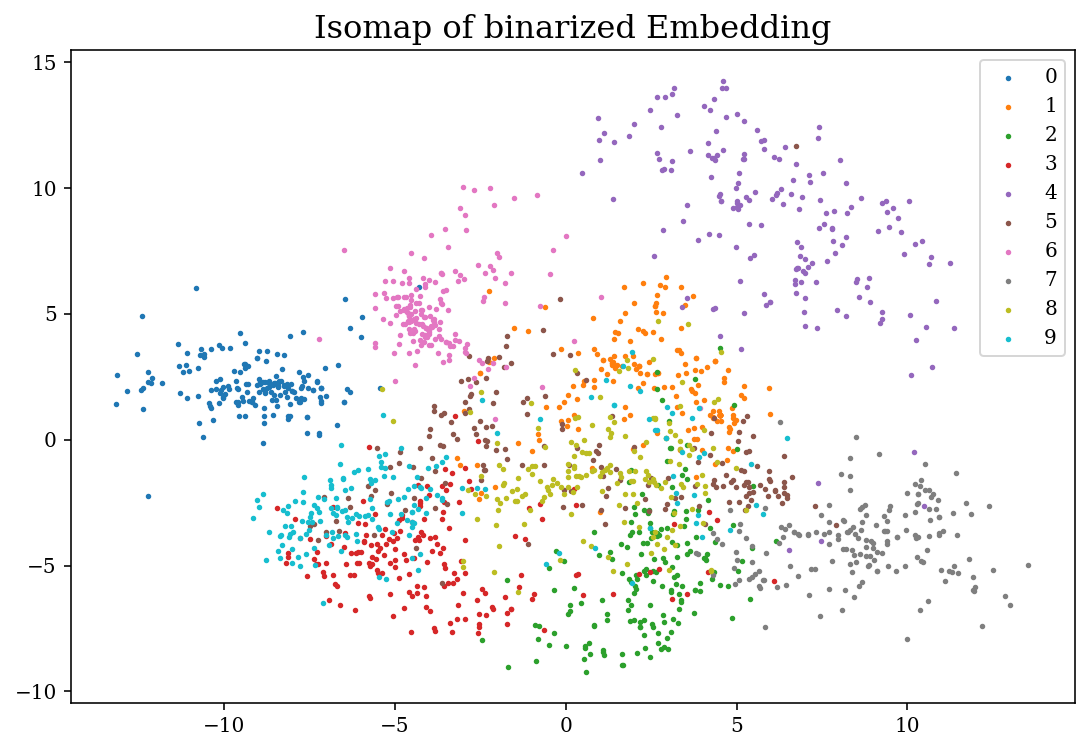

In [196]:
plot2dproj(x_iso,labels, "Isomap of binarized")

Astonishignly not bad?

In [156]:
latent_dim=2
train = torch.tensor(ims, dtype=torch.get_default_dtype())
X_init = torch.tensor(x_iso[:,:latent_dim],dtype=torch.get_default_dtype())
X = Parameter(X_init.clone())

rbf =  gp.kernels.RBF(input_dim=latent_dim,lengthscale = X_init.max(0)[0] - X_init.mean(0))
m12 = gp.kernels.Exponential(input_dim=latent_dim,lengthscale = X_init.max(0)[0] - X_init.mean(0))
m32 = gp.kernels.Matern32(input_dim=latent_dim,lengthscale = X_init.max(0)[0] - X_init.mean(0))
m52 = gp.kernels.Matern52(input_dim=latent_dim,lengthscale = X_init.max(0)[0] - X_init.mean(0))
K = rbf
#K = gp.kernels.Sum(K,m32)
K = gp.kernels.Sum(K,m52)

In [161]:
Y = torch.tensor(ims, dtype=torch.get_default_dtype()).t()

In [198]:
Y.shape

torch.Size([64, 1797])

In [220]:
cutoff = int(0.85*ims.shape[0])
X_train, X_test = X[:cutoff], X[cutoff:]
Y_train, Y_test = Y[:,:cutoff], Y[:,cutoff:]

In [223]:
binary_likelihood = gp.likelihoods.Binary()
gpc = gp.models.VariationalGP(X_train, Y_train ,kernel=K,likelihood=binary_likelihood,jitter=1e-4, whiten=True) 
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

In [224]:
from gp_train_tqdm import train

ModuleNotFoundError: No module named 'gp_train_tqdm'

In [ ]:
gpc.eval()
f_loc, f_var = gpc(X_test)
pred = gpc.likelihood(f_loc, f_var)

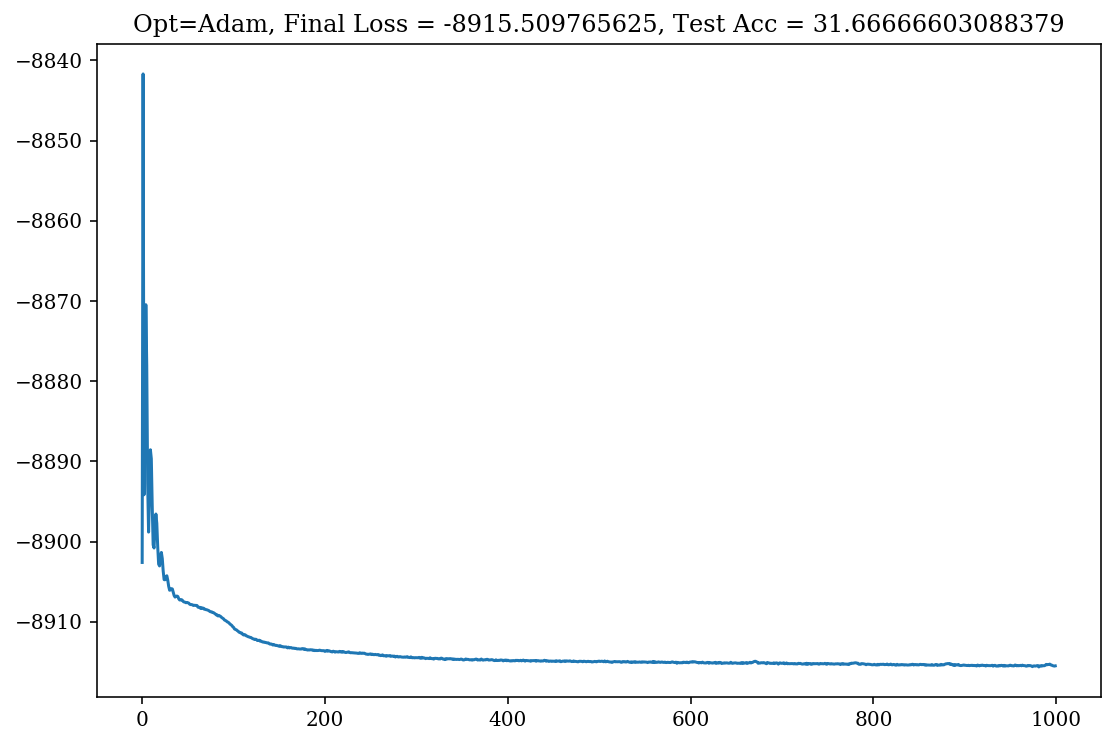

In [208]:
plt.plot(losses)
plt.title(f'Opt=Adam, Final Loss = {str(losses[-1])}, Test Acc = {(pred.eq(Y_test).sum()*1./Y_test.shape[-1]).item()}')
plt.savefig('adam_elbo.png')
plt.show()

In [214]:
pred = gpc.likelihood(f_loc,f_var)
(pred.eq(Y_test).sum()*1./Y_test.shape[-1]).item()

31.907407760620117

In [210]:
Y_test.shape

torch.Size([64, 270])

In [190]:
(labels==4).argmax()

4

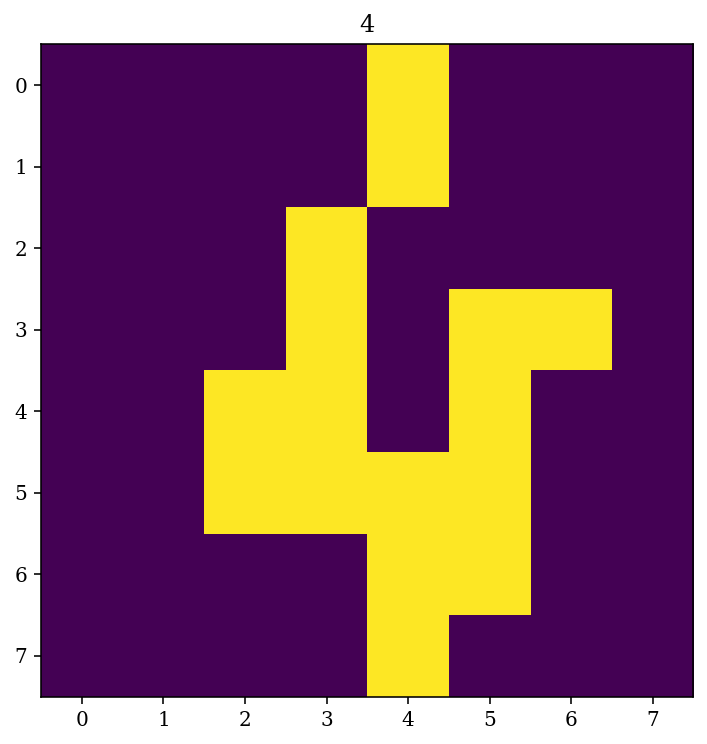

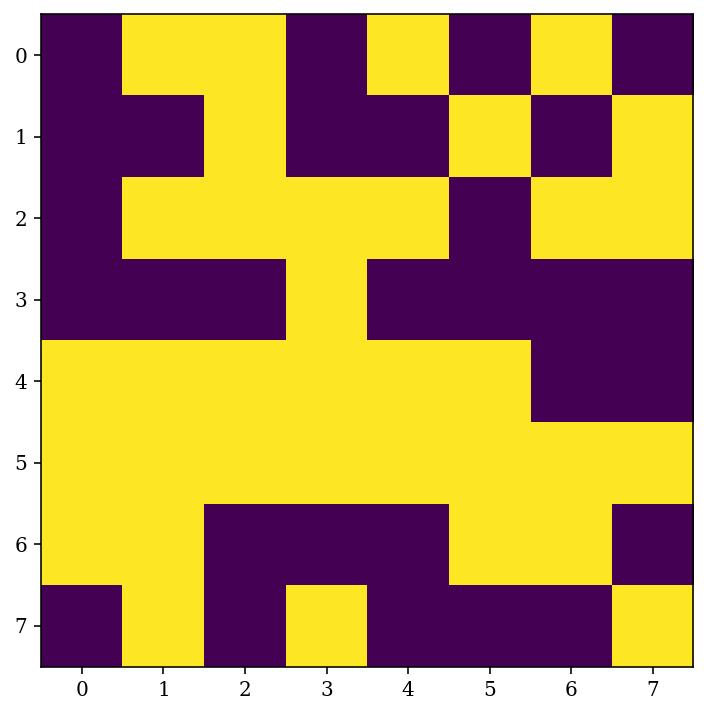

In [193]:
num = 4
plt.imshow(ims[num].reshape(8,8))
plt.title(labels[num])
plt.show()
gpc.eval()
loc, var = gpc(X[num].unsqueeze(0))
pred = gpc.likelihood(loc, var)
plt.imshow(pred.detach().numpy().reshape(8,8))
plt.show()

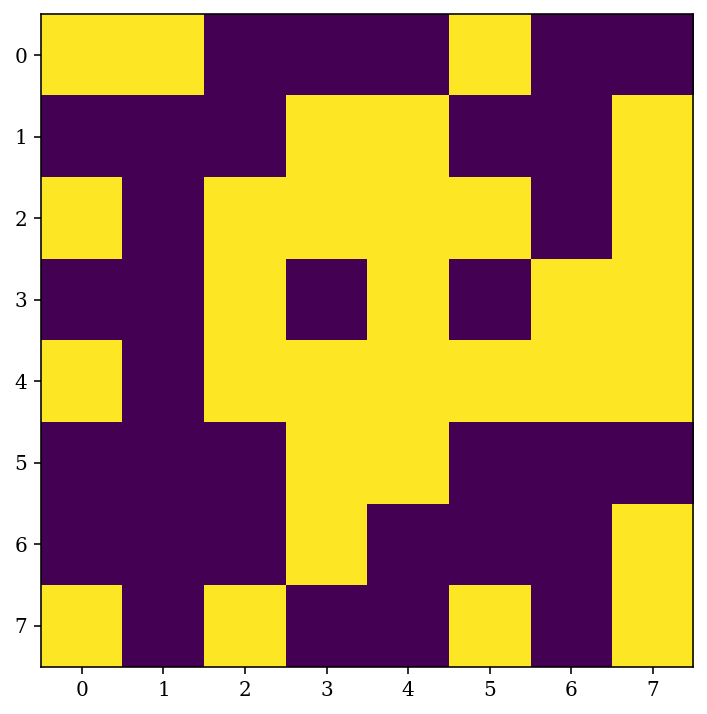

In [175]:
X.shape

torch.Size([1797, 2])

In [192]:
from torchvision import datasets

In [ ]:
datasets.